In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from os.path import join
import sys
import re
import sentencepiece as spm
sys.path.append("../")
sys.path.append("../model")

## 경고 무시
import warnings
warnings.filterwarnings('ignore')

## 시각화 툴
import matplotlib.pyplot as plt
import seaborn as sns

## encoding 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras import regularizers

## vocabulary
import tensorflow_datasets as tfds

## preprocessor
from custom_preprocessor import Preprocessor

In [9]:
preprocessor = Preprocessor()
preprocessed_train, preprocessed_test = preprocessor.preprocess()

In [11]:
max_len = preprocessed_train["conversation"].apply(lambda x: len(x.split())).max()
print(f"최대 문장 길이: {max_len}")

최대 문장 길이: 239


In [10]:
## CLASS_NAMES에 '일반 대화'를 포함시킴
CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화']

# 수동 매핑 설정
class_mapping = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}


# 'class' 열을 수동 매핑 적용하기 전에 문자열로 변환
preprocessed_train['class'] = preprocessed_train['class'].astype(str).map(class_mapping)
labels = preprocessed_train['class']

# sentencepiece를 이용한 tokenizer 생성

In [12]:
# 토크나이저 생성 함수
def generate_tokenizer(corpus,
                       vocab_size,
                       lang="ko",
                       pad_id=0,
                       bos_id=1,
                       eos_id=2,
                       unk_id=3):
    # 문장 데이터를 파일로 저장
    with open(f"{lang}_corpus.txt", "w") as f:
        for sentence in corpus:
            f.write(sentence + "\n")
    
    model_prefix = f"{lang}_tokenizer"
    
    # Train SentencePiece tokenizer
    spm.SentencePieceTrainer.train(
        f"--input={lang}_corpus.txt --model_prefix={model_prefix} --vocab_size={vocab_size}" + 
        f" --pad_id={pad_id} --pad_piece=[PAD]" +
        f" --unk_id={unk_id} --unk_piece=[UNK]" +
        f" --bos_id={bos_id} --bos_piece=[BOS]" +
        f" --eos_id={eos_id} --eos_piece=[EOS]" +
        " --model_type=unigram --max_sentence_length=999999")

    # Load tokenizer
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.load(f"{model_prefix}.model")
    
    return tokenizer

In [14]:
## Tokenizer 설정
SRC_VOCAB_SIZE = 12639  # 어휘 크기 설정(20000으로 했더니 오류 뜸)
tokenizer = generate_tokenizer(preprocessed_train['conversation'], SRC_VOCAB_SIZE, 'ko')

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=ko_corpus.txt --model_prefix=ko_tokenizer --vocab_size=12639 --pad_id=0 --pad_piece=[PAD] --unk_id=3 --unk_piece=[UNK] --bos_id=1 --bos_piece=[BOS] --eos_id=2 --eos_piece=[EOS] --model_type=unigram --max_sentence_length=999999
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ko_corpus.txt
  input_format: 
  model_prefix: ko_tokenizer
  model_type: UNIGRAM
  vocab_size: 12639
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 999999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extreme

In [19]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 400
EMBEDDING_DIM = 256

In [20]:
## 문장 길이를 제한하여 필터링
MAX_SEQUENCE_LENGTH = 400  # 문장 길이를 400자로 제한

filtered_train = preprocessed_train[preprocessed_train['conversation'].apply(len) <= MAX_SEQUENCE_LENGTH]
print("원본 데이터 크기:", len(preprocessed_train))
print("전처리 후 데이터 크기:", len(filtered_train))

원본 데이터 크기: 4976
전처리 후 데이터 크기: 4838


In [21]:
## 테스트 데이터 로드 및 전처리
test_data_path = "~/data/test.json"
test_data = pd.read_json(test_data_path)
test_data = test_data.T
test_data.head()

,text
t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...


In [22]:
# 패딩 처리
pad_train = tf.keras.preprocessing.sequence.pad_sequences(
    [tokenizer.encode_as_ids(sentence) for sentence in filtered_train['conversation']],
    maxlen=MAX_SEQUENCE_LENGTH,  # 최대 시퀀스 길이 지정
    padding='post',              # 문장의 뒤쪽에 패딩 추가
    value=0                      # 패딩에 사용할 값 (SentencePiece에서 pad_id로 설정된 값이 0이라면 그대로 둡니다)
)


In [23]:
print(pad_train)

[[   35   831   154 ...     0     0     0]
 [  593   353    21 ...     0     0     0]
 [ 1251 10601    48 ...     0     0     0]
 ...
 [  104  2838   937 ...     0     0     0]
 [  306   331   311 ...     0     0     0]
 [ 3014  1828   486 ...     0     0     0]]


In [24]:
pad_train.shape

(4838, 400)

In [29]:
# 원-핫 인코딩으로 변환
Y = pd.get_dummies(filtered_train['class']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (4838, 5)


In [27]:
#훈련 데이터와 검증 데이터를 나눔
X_train, X_val, Y_train, Y_val = train_test_split(pad_train, Y, test_size=0.10, random_state=42)
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)

(4354, 400) (4354, 5)
(484, 400) (484, 5)


# LSTM

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# 모델 생성
model = Sequential()
model.add(Embedding(SRC_VOCAB_SIZE, EMBEDDING_DIM, input_length=X_train.shape[1]))  # SRC_VOCAB_SIZE로 수정
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))  # 클래스 수 5로 수정

# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습 파라미터 설정
epochs = 100
batch_size = 64

# 모델 학습
history = model.fit(
    X_train, Y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, Y_val),  
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
)

Epoch 1/100
69/69 [==============================] - 109s 1s/step - loss: 1.6097 - accuracy: 0.2044 - val_loss: 1.6089 - val_accuracy: 0.2438
Epoch 2/100
69/69 [==============================] - 94s 1s/step - loss: 1.6093 - accuracy: 0.2097 - val_loss: 1.6076 - val_accuracy: 0.2438
Epoch 3/100
69/69 [==============================] - 94s 1s/step - loss: 1.6083 - accuracy: 0.2157 - val_loss: 1.6136 - val_accuracy: 0.1880
Epoch 4/100
69/69 [==============================] - 94s 1s/step - loss: 1.6094 - accuracy: 0.2049 - val_loss: 1.6092 - val_accuracy: 0.1839
Epoch 5/100
69/69 [==============================] - 94s 1s/step - loss: 1.6087 - accuracy: 0.2056 - val_loss: 1.6086 - val_accuracy: 0.2438


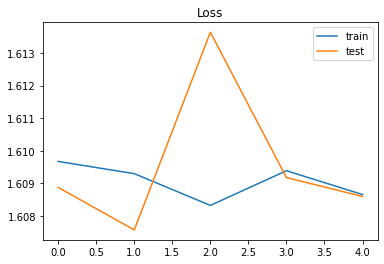

In [31]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

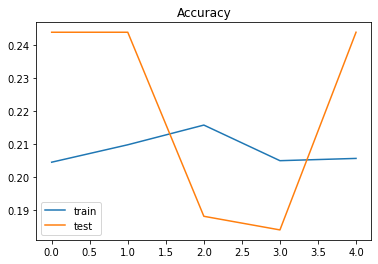

In [32]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

# F1 스코어 확인하기

In [34]:
from sklearn.metrics import f1_score
import numpy as np

# 모델 예측 (검증 데이터를 사용하여 예측)
y_pred = model.predict(X_val)

# 예측 결과를 클래스 레이블로 변환 (가장 높은 확률을 가지는 인덱스를 선택)
y_pred_classes = np.argmax(y_pred, axis=1)

# 실제 값도 원-핫 인코딩을 클래스 레이블로 변환
y_true = np.argmax(Y_val, axis=1)

# F1 스코어 계산 (다중 클래스 분류에서는 average='weighted' 또는 'macro'를 사용할 수 있음)
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f'F1 Score: {f1}')

F1 Score: 0.09557672771203428
